In [1]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
from tqdm import tqdm_notebook
import seaborn as sns
from helpers.normalization import normalize, denormalize, renormalize
import control
import scipy

Using TensorFlow backend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wconlin/.conda/envs/tfg

In [2]:
num_cores = 4
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
session = tf.Session(config=config)
K.set_session(session)

In [3]:
%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 18}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

In [4]:
model_path = '~/run_results_11_19/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-thomson_temp_EFIT02-thomson_dens_EFIT02-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_ftop-True_25Nov19-15-05_Scenario-10.h5'
model = keras.models.load_model(os.path.expanduser(model_path), compile=False)
print('loaded model: ' + model_path.split('/')[-1])
file_path = model_path[:-3] + '_params.pkl'
with open(os.path.expanduser(file_path), 'rb') as f:
     analysis_params = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(analysis_params.keys()))
analysis_params['dt'] = 0.05

loaded model: model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-thomson_temp_EFIT02-thomson_dens_EFIT02-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_ftop-True_25Nov19-15-05_Scenario-10.h5
loaded dict: model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-thomson_temp_EFIT02-thomson_dens_EFIT02-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_ftop-True_25Nov19-15-05_Scenario-10_params.pkl
with parameters: dict_keys(['process_data', 'x_weight', 'u_weight', 'discount_factor', 'window_length', 'actuator_names', 'profile_names', 'scalar_names', 'profile_downsample', 'state_encoder_type', 'state_decoder_type', 'control_encoder_type', 'control_decoder_type', 'state_encoder_kwargs', 'state_decoder_kwargs', 'control_encoder_kwargs', 'control_decoder_kwargs', 'state_latent_dim', 'control_latent_dim', 'batch_size', 'epochs', 'flattop_only', 'raw_data_path', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'sh

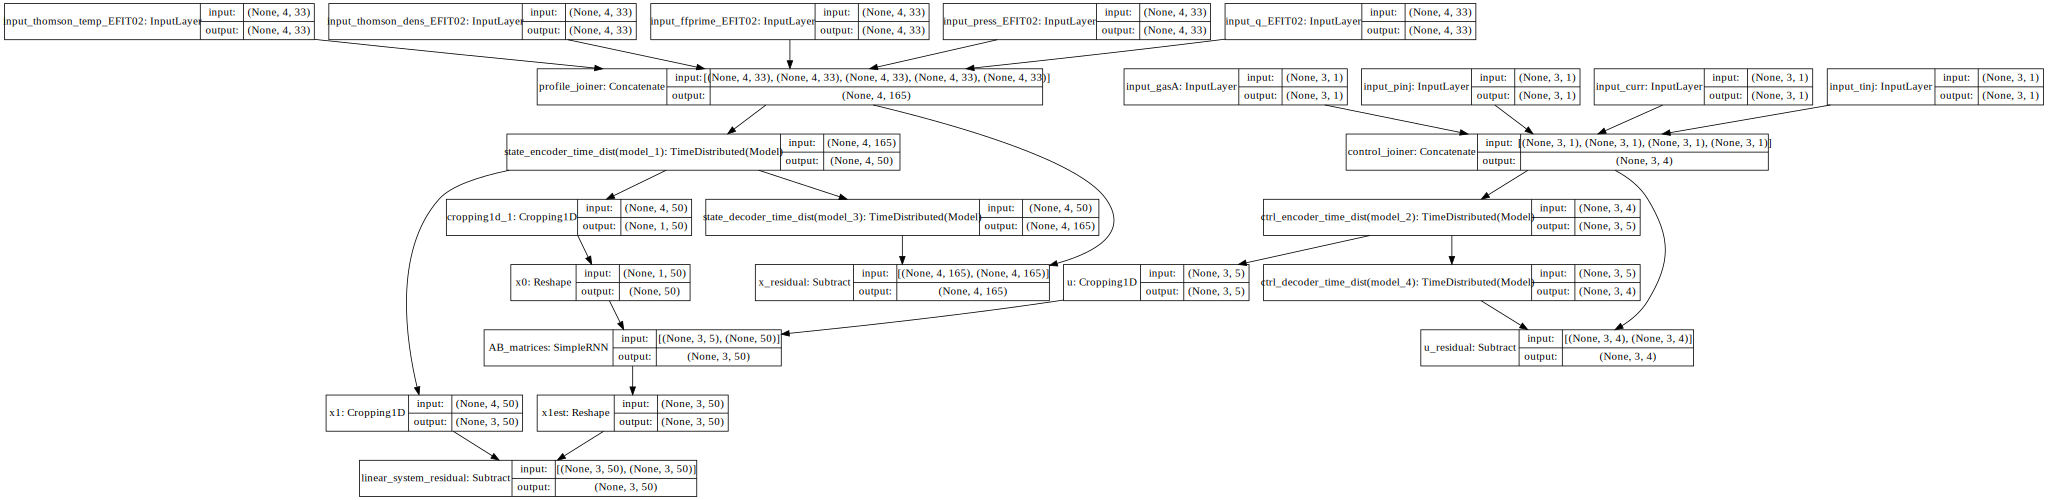

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True,show_layer_names=True,rankdir='TB').create(prog='dot', format='svg'))

In [6]:
data_path = '/scratch/gpfs/jabbate/mixed_data/final_data_batch_154.pkl'
rawdata = {}
with open(data_path,'rb') as f:
    rawdata.update(pickle.load(f, encoding='latin1'))

In [7]:
actuator_names = ['pinj','tinj','curr','gasA']
profile_names = ['temp','dens','press_EFIT02','rotation','ffprime_EFIT02','q_EFIT02']
sig_names = actuator_names + profile_names
normalization_method = 'RobustScaler'
lookbacks = {}
actuator_lookback = 6
for sig in actuator_names:
    lookbacks[sig] = actuator_lookback
for sig in profile_names:
    lookbacks[sig] = 1
lookahead = 3
sample_step=1
window_overlap=0
window_length=1
uniform_normalization=True
data, valdata, normalization_params = process_data(rawdata, sig_names, normalization_method, window_length,
                                                    window_overlap, lookbacks, lookahead, sample_step,
                                                    uniform_normalization, train_frac=0.8, val_frac=0.2,
                                                    nshots=12000,verbose=1, flattop_only=True)

Signals: curr, dens, ffprime_EFIT02, gasA, pinj, press_EFIT02, q_EFIT02, rotation, temp, tinj
Number of useable shots:  46
Number of shots used:  46
Total number of timesteps:  12314


Gathering: 100%|##########| 46/46 [00:00<00:00, 71.70it/s]

Shots with Complete NaN: [171187.]



Stacking: 100%|##########| 19/19 [00:00<00:00, 76.31it/s]

8592 samples total


Removing ECH
Removed 4000 samples
4592 samples remaining
Removing weird gas
4592 samples remaining after pruning


Splitting: 100%|##########| 19/19 [00:00<00:00, 1120.54it/s]

Total number of samples:  4592
Number of training samples:  3673
Number of validation samples:  919


In [8]:
np.mean(np.diff(data['time']))

20.0

In [9]:
def get_AB(model):
    A = model.get_layer('AB_matrices').get_weights()[1].T
    B = model.get_layer('AB_matrices').get_weights()[0].T
    return A,B

def get_submodels(model):
    from keras.models import Model
    state_encoder = model.get_layer('state_encoder_time_dist').layer.layers[-1]
    control_encoder = model.get_layer('ctrl_encoder_time_dist').layer.layers[-1]
    state_decoder = Model(model.get_layer('state_decoder_time_dist').layer.layers[0].input,
                          model.get_layer('state_decoder_time_dist').layer.layers[-2].get_output_at(1),
                         name='state_decoder')    
    control_decoder = Model(model.get_layer('ctrl_decoder_time_dist').layer.layers[0].input,
                            model.get_layer('ctrl_decoder_time_dist').layer.layers[-2].get_output_at(1),
                           name='control_decoder')
 
    return state_encoder, state_decoder, control_encoder, control_decoder

In [10]:
A,B = get_AB(model)
state_encoder, state_decoder, control_encoder, control_decoder = get_submodels(model)

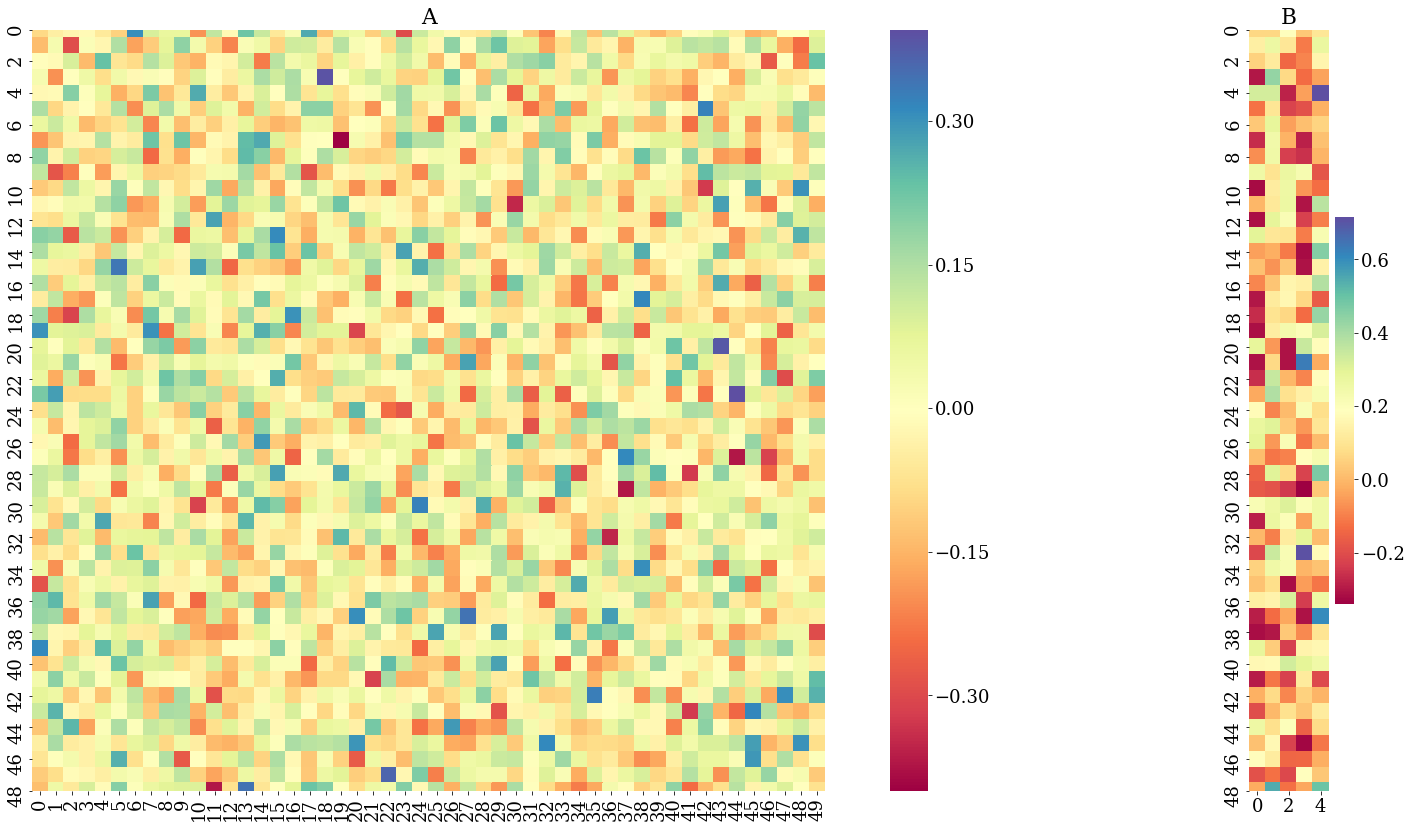

In [43]:
def plot_autoencoder_AB(model,analysis_params, filename=None, **kwargs):
    A,B = get_AB(model)
    f, axes = plt.subplots(1, 2, figsize=(28, 14),
                           gridspec_kw={'width_ratios': [analysis_params['state_latent_dim'], 
                                                         analysis_params['control_latent_dim']]})
    sns.heatmap(A, 
                cmap=kwargs.get('cmap','Spectral'),
                annot=kwargs.get('annot',False), 
                square=kwargs.get('square',True), 
                robust=kwargs.get('robust',False), 
                ax=axes[0]).set_title('A')
    sns.heatmap(B,
                cmap=kwargs.get('cmap','Spectral'), 
                annot=kwargs.get('annot',False), 
                square=kwargs.get('square',True), 
                robust=kwargs.get('robust',False), 
                ax=axes[1]).set_title('B')

    if filename:
        f.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return f, html
    return f

f = plot_autoencoder_AB(model,analysis_params)

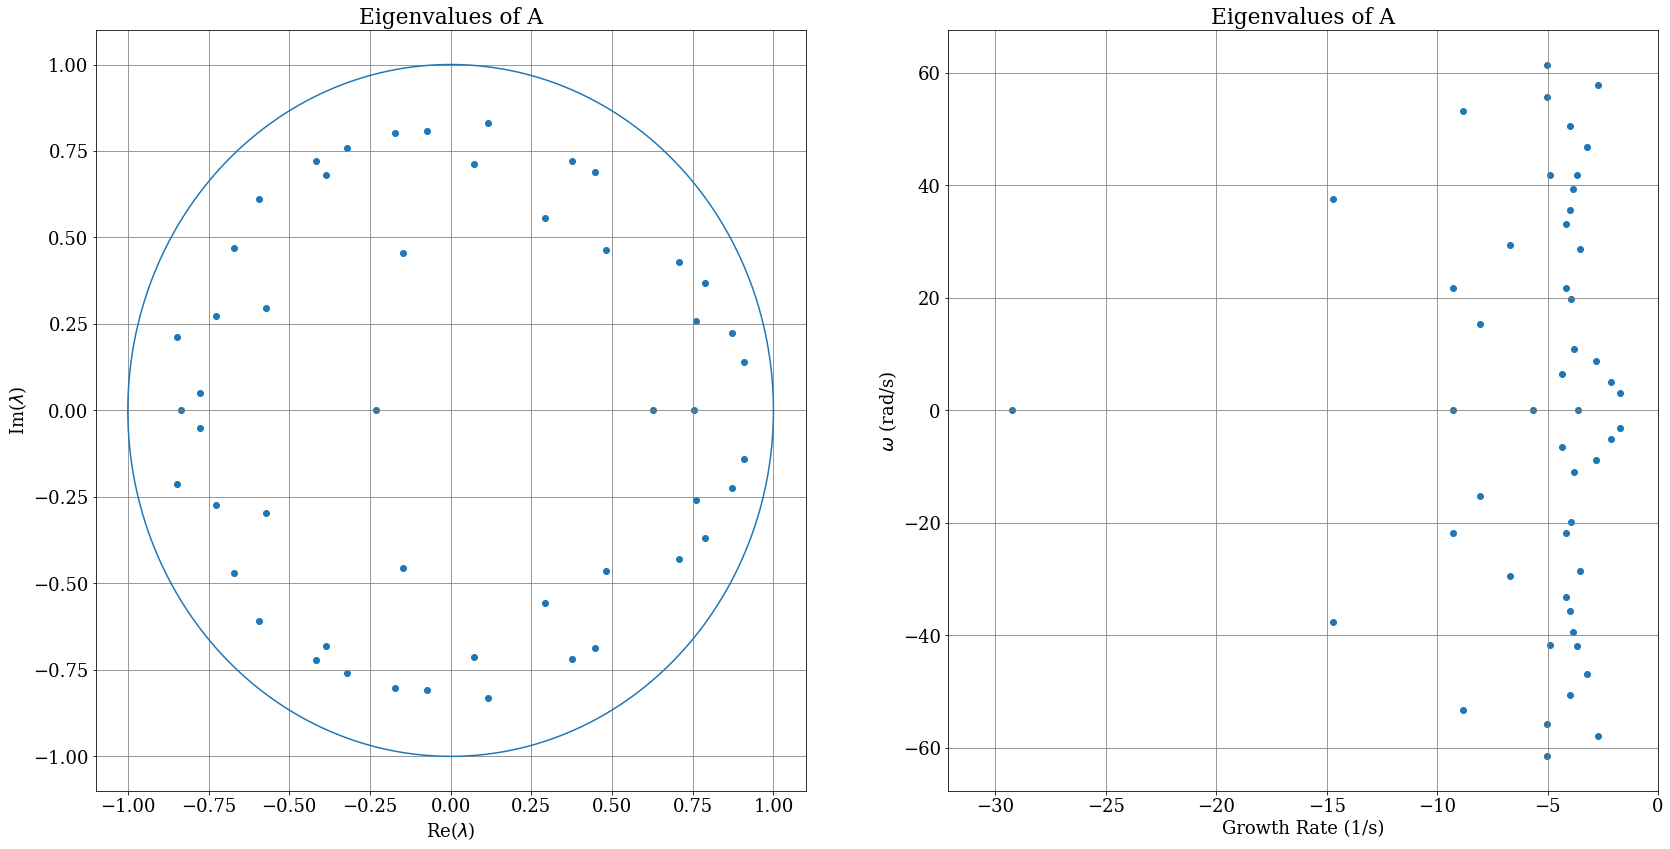

In [44]:
## Plot spectrum of A
def plot_autoencoder_spectrum(model,analysis_params, filename=None, **kwargs):
    dt = analysis_params['dt']
    A,B = get_AB(model)
    eigvals, eigvecs = np.linalg.eig(A)
    logeigvals = np.log(eigvals)
    for i, elem in enumerate(logeigvals):
        if abs(np.imag(elem)-np.pi)<np.finfo(np.float32).resolution:
            logeigvals[i] = np.real(elem) + 0j
    logeigvals = logeigvals/dt

    f, axes = plt.subplots(1, 2, figsize=(28, 14))
    axes[0].scatter(np.real(eigvals),np.imag(eigvals))
    t = np.linspace(0,2*np.pi,1000)
    axes[0].plot(np.cos(t),np.sin(t))

    axes[0].set_title('Eigenvalues of A')
    axes[0].grid(color='gray')
    axes[0].set_xlabel('Re($\lambda$)')
    axes[0].set_ylabel('Im($\lambda$)')


    axes[1].scatter(np.real(logeigvals),np.imag(logeigvals))
    axes[1].set_title('Eigenvalues of A')
    axes[1].grid(color='gray')
    axes[1].set_xlabel('Growth Rate (1/s)')
    axes[1].set_ylabel('$\omega$ (rad/s)')
    axes[1].set_xlim((1.1*np.min(np.real(logeigvals)),np.maximum(1.1*np.max(np.real(logeigvals)),0)))
    
    if filename:
        f.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return f, html
    return f
        
f = plot_autoencoder_spectrum(model, analysis_params)


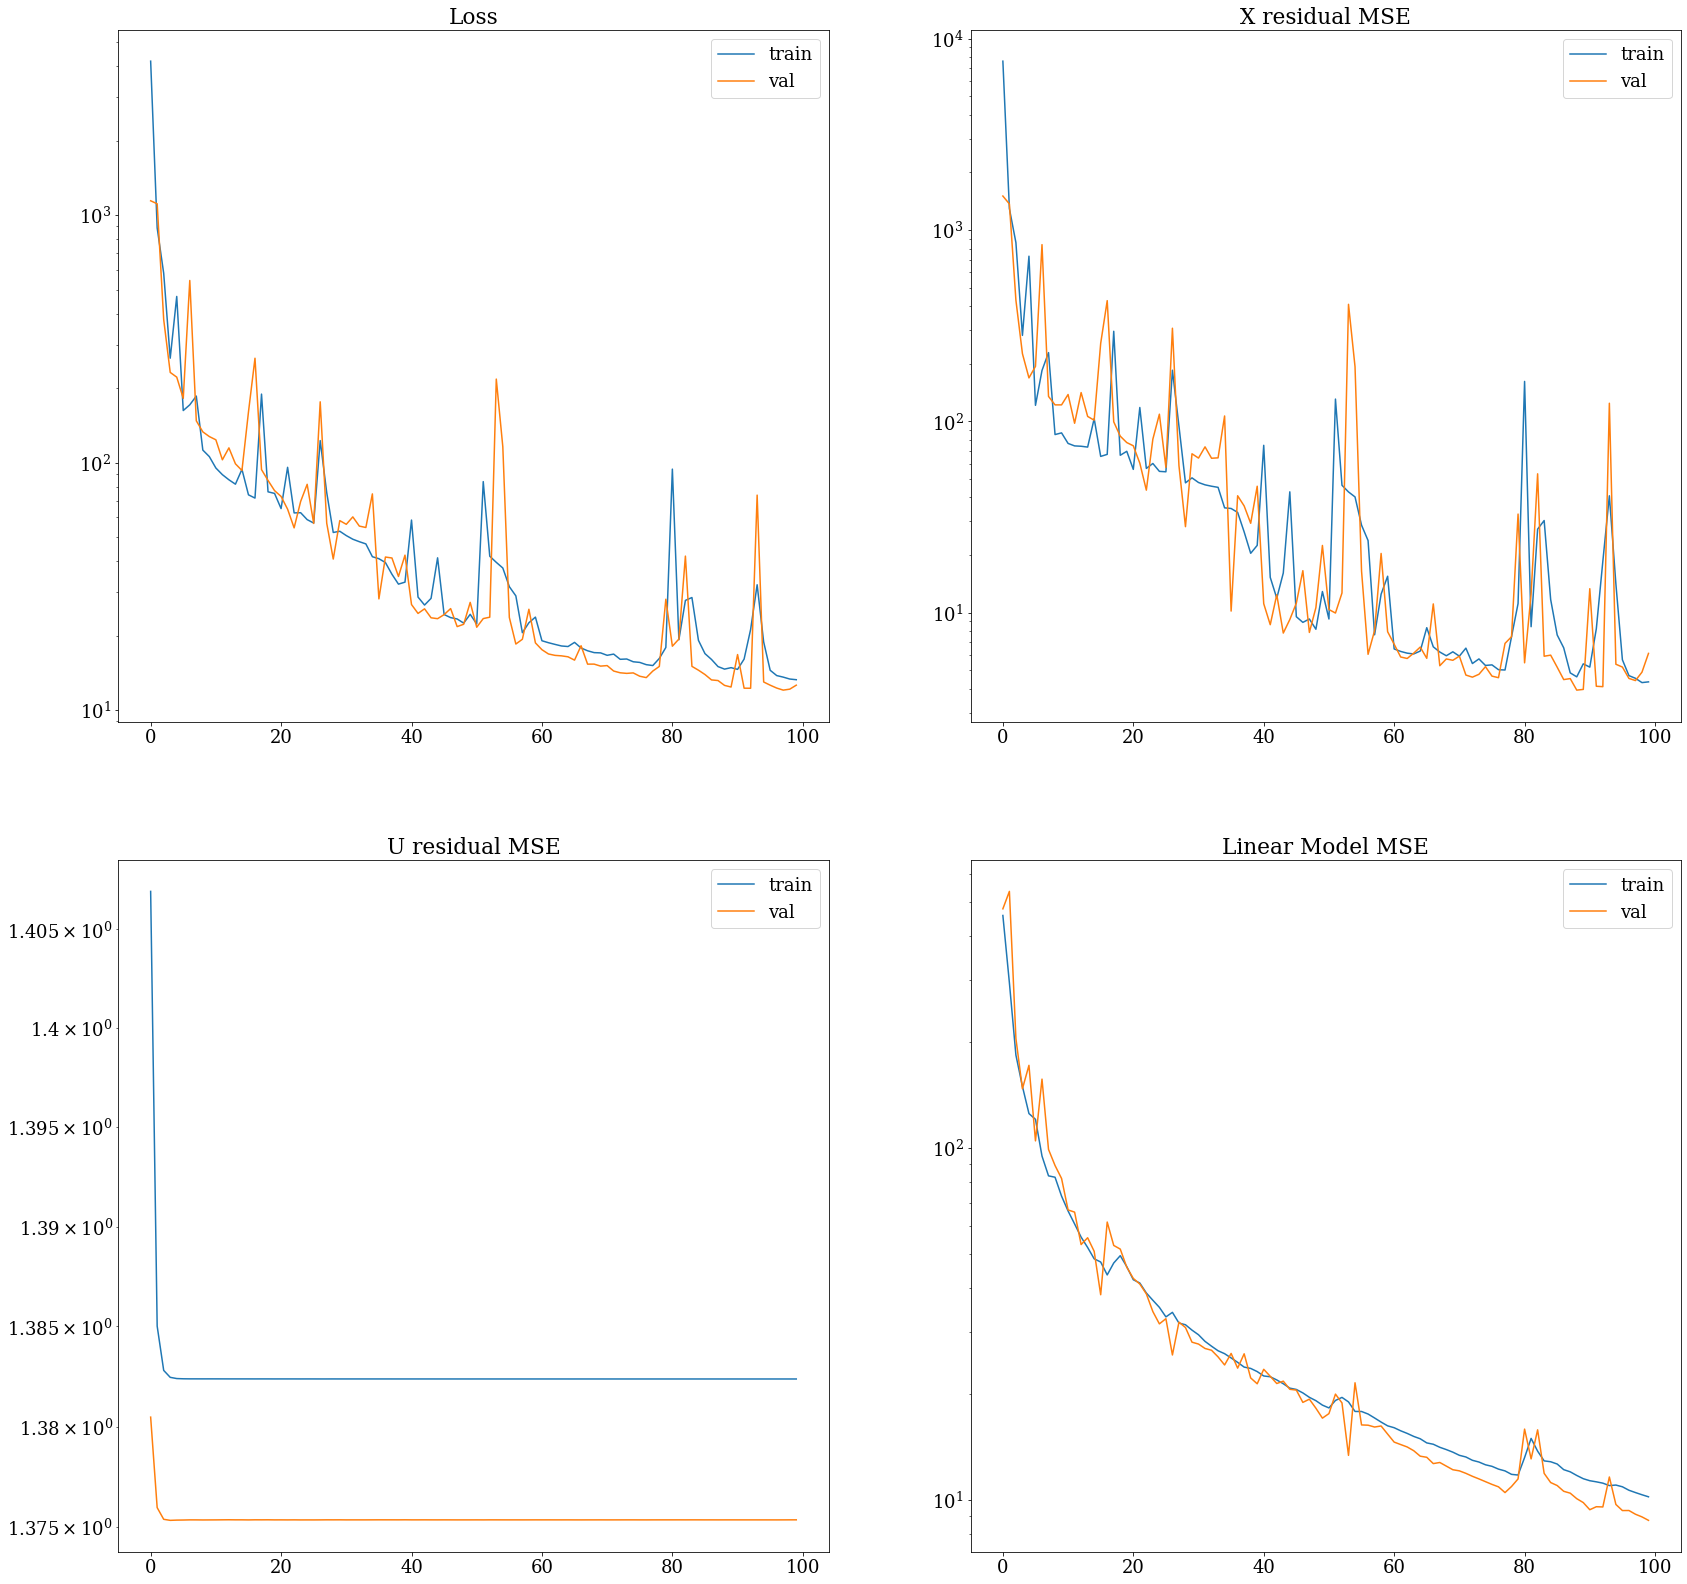

In [51]:
def plot_autoencoder_training(model,analysis_params,filename=None,**kwargs):

    f, axes = plt.subplots(2, 2, figsize=(28, 28))
    axes[0,0].semilogy(analysis_params['history']['loss'],label='train')
    axes[0,0].semilogy(analysis_params['history']['val_loss'],label='val')
    axes[0,0].set_title('Loss')
    axes[0,0].legend()

    axes[0,1].semilogy(analysis_params['history']['x_residual_mean_squared_error'],label='train')
    axes[0,1].semilogy(analysis_params['history']['val_x_residual_mean_squared_error'],label='val')
    axes[0,1].set_title('X residual MSE')
    axes[0,1].legend()

    axes[1,0].semilogy(analysis_params['history']['u_residual_mean_squared_error'],label='train')
    axes[1,0].semilogy(analysis_params['history']['val_u_residual_mean_squared_error'],label='val')
    axes[1,0].set_title('U residual MSE')
    axes[1,0].legend()

    axes[1,1].semilogy(analysis_params['history']['linear_system_residual_mean_squared_error'],label='train')
    axes[1,1].semilogy(analysis_params['history']['val_linear_system_residual_mean_squared_error'],label='val')
    axes[1,1].set_title('Linear Model MSE')
    axes[1,1].legend()
    
    if filename:
        f.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return f, html
    return f
        
f = plot_autoencoder_training(model,analysis_params)


In [46]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

def write_results(scenario,model):
    
    if 'image_path' not in scenario.keys():
        scenario['image_path'] = 'https://jabbate7.github.io/plasma-profile-predictor/results/' + scenario['runname']
    
    base_sheet_path = "https://docs.google.com/spreadsheets/d/1GbU2FaC_Kz3QafGi5ch97mHbziqGz9hkH5wFjiWpIRc/edit#gid=0"
    scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name(os.path.expanduser('~/plasma-profile-predictor/drive-credentials.json'), scope)
    client = gspread.authorize(creds)
    sheet = client.open_by_url(base_sheet_path).sheet1
    
    write_scenario_to_sheets(scenario,sheet)
    rowid = sheet.find(analysis_params['runname']).row
    scenario['sheet_path'] = base_sheet_path + "&range={}:{}".format(rowid,rowid)
    
    results_dir =os.path.expanduser('~/plasma-profile-predictor/results/'+scenario['runname'])  
    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    os.chdir(results_dir)
    f = open('index.html','w+')
    f.write('<html><head></head><body>')
    html = scenario_to_html(scenario)
    f.write(html + '<p>\n')
    _, html = plot_autoencoder_training(model,scenario, filename='training.png')
    f.write(html + '<p>\n')
    _, html = plot_AB(model,scenario, filename='AB.png')
    f.write(html + '<p>\n')
    _, html = plot_spectrum(model,scenario, filename='spectrum.png')
    f.write(html + '<p>\n')
    f.write('</body></html>')
    f.close()
    
    
def write_scenario_to_sheets(scenario,sheet):
    sheet_keys = sheet.row_values(1)
    row = [None]*len(sheet_keys)
    for i,key in enumerate(sheet_keys):
        if key in scenario.keys():
            row[i] = str(scenario[key])
        elif key in scenario.get('history',{}):
            row[i] = str(scenario['history'][key][-1])
    sheet.append_row(row)

def scenario_to_html(scenario):
    foo = {k:v for k,v in scenario.items() if k not in ['history','normalization_dict','history_params']}
    def printitems(dictObj, indent=0):
        p=[]
        p.append('<ul>\n')
        for k,v in dictObj.items():
            if isinstance(v, dict):
                p.append('<li><b>'+ str(k)+ '</b>: ')
                p.append(printitems(v))
                p.append('</li>\n')
            elif k in ['image_path','sheet_path']:
                p.append("<a href=\"" + str(v) + "\">" + str(k) + "</a>\n")          
            else:
                p.append('<li><b>'+ str(k)+ '</b>: '+ str(v)+ '</li>\n')
        p.append('</ul>\n')
        return ''.join(p)
    return printitems(foo)

In [38]:
dt = .05
# Ac = logm(Ad)/dt
Ac = scipy.linalg.logm(A)/dt
# Bc = inv(Ad-I)*Ac*Bd
Bc = np.matmul(np.linalg.inv(A-np.eye(analysis_params['state_latent_dim'])),np.matmul(Ac,B))
C = np.eye(analysis_params['state_latent_dim'])
D = np.zeros((analysis_params['state_latent_dim'],analysis_params['control_latent_dim']))
sys = control.StateSpace(Ac,Bc,C,D)

logm result may be inaccurate, approximate err = 2.6861127030165117e-06


In [42]:
np.linalg.matrix_rank(control.ctrb(Ac,Bc),1e-6)

50

In [43]:
1/np.linalg.cond(control.ctrb(Ac,Bc))

2.54872065395922e-29

In [50]:
os.getcwd()

'/home/wconlin/plasma-profile-predictor'

In [49]:
os.chdir('..')

In [14]:
results_dir =os.path.expanduser('~/plasma-profile-predictor/results/'+analysis_params['runname'])
os.chdir(results_dir)

In [36]:
scenario = analysis_params
base_sheet_path = "https://docs.google.com/spreadsheets/d/1GbU2FaC_Kz3QafGi5ch97mHbziqGz9hkH5wFjiWpIRc/edit#gid=0"
scope = ['https://spreadsheets.google.com/feeds',
     'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(os.path.expanduser('~/plasma-profile-predictor/drive-credentials.json'), scope)
client = gspread.authorize(creds)
sheet = client.open_by_url(base_sheet_path).sheet1
write_scenario_to_sheets(scenario,sheet)
results_dir =os.path.expanduser('~/plasma-profile-predictor/results/'+scenario['runname'])
img_path = 'https://jabbate7.github.io/plasma-profile-predictor/results/' + scenario['runname']

rowid = sheet.find(analysis_params['runname']).row
sheet_path = base_sheet_path + "&range={}:{}".format(rowid,rowid)

In [34]:
sheet.find(analysis_params['runname']).row

2

In [37]:
sheet_path

'https://docs.google.com/spreadsheets/d/1GbU2FaC_Kz3QafGi5ch97mHbziqGz9hkH5wFjiWpIRc/edit#gid=0&range=2:2'